In [63]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score
from sklearn.model_selection import GridSearchCV     

In [81]:
class stock():
    def __init__(self,ticker):
        self.ticker = ticker

    def find_stock_data(self,start_date,end_date):
        data = yf.download(self.ticker, start=start_date, end=end_date)
        return data

    def create_features(self,start_date,end_date):
        
        data = self.find_stock_data(start_date,end_date)
        
        ####################Defining correlation feature########################
        # Define the horizon
        horizon = 20
        # Calculate the rolling average volume over the past 20 days
        data['avg_volume_20d'] = data['Volume'].rolling(window=20).mean()
        
        # Reset index to get row numbers instead of timestamps
        data = data.reset_index()
        # Define a function to calculate the correlation for a given row index
        def calculate_correlation(row):
            idx = row.name  # Row index
            if idx < horizon - 1 or idx < 19:
                return np.nan  # Not enough data to compute correlation
            close_vector = data['Close'].iloc[idx - horizon + 1: idx + 1].values
            volume_vector = (data['Volume'].iloc[idx - horizon + 1: idx + 1] /
                             data['avg_volume_20d'].iloc[idx - horizon + 1: idx + 1]).values
            return np.corrcoef(close_vector, volume_vector)[0, 1]
        
        # Apply the function row-wise using .apply()
        data['correlation'] = data.apply(calculate_correlation, axis=1)
        
        # Set the index back to the original datetime index if needed
        data = data.set_index('Date')

        #################### Defining log difference ########################

        # Calculate the log difference for 'Open', 'Close', 'High', 'Low', 'Volume'
        columns_to_calculate = ['Open', 'Close', 'High', 'Low', 'Volume']
        for column in columns_to_calculate:
            data[f'log_diff_{column}'] = np.log(data[column] / data[column].shift(1))

        #################### Defining target values ########################

        data.loc[:, 'Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
        interval = 14
        data.loc[:, 'Target_sma'] = (data['Close'].rolling(window= interval).mean().shift(-1) > data['Close'].rolling(window= interval).mean()).astype(int)
       
        #################### Defining stock trend features ########################

        horizons = [2,5,60,250,1000]
        new_predictors = []
        data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
        for horizon in horizons:
            rolling_averages = data.rolling(horizon).mean()
            
            ratio_column = f"Close_Ratio_{horizon}"
            data[ratio_column] = data["Close"] / rolling_averages["Close"]
            
            trend_column = f"Trend_{horizon}"
            data[trend_column] = data.shift(1).rolling(horizon).sum()["Target"]
            data[f'Volatility_{horizon}'] = data['Log_Returns'].rolling(window=horizon).std()
        
            new_predictors+= [ratio_column, trend_column]
            data = data.dropna()

        return data
        
    def random_forest(self,df,features,target,start_date,end_date):
        
        data = df
        # Split data into training (80%) and testing (20%) sets
        split_index = int(len(data) * 0.8)
        train_data = data.iloc[:split_index]
        test_data = data.iloc[split_index:]
        
        # Separate features (X) and target (y)
        X_train = train_data[features]
        y_train = train_data[target].values.ravel()
        X_test = test_data[features]
        y_test = test_data[target].values.ravel()
        
        # Define hyperparameter grid
        param_grid = {
            'n_estimators': [50, 100, 200],  # Number of trees in the forest
            'max_depth': [10, 20, 30, 40],  # Maximum depth of the tree
            'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
            'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
            'max_features': ['sqrt'],  # Number of features to consider at each split
            'bootstrap': [True]  # Whether to bootstrap samples when building trees
        }
        
        # Initialize Random Forest model
        rf_model = RandomForestClassifier(random_state=42)
        
        # Perform grid search with 5-fold cross-validation using precision as the metric
        grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, 
                                   scoring='precision', verbose=2, n_jobs=-1)
        
        # Fit grid search to the training data
        grid_search.fit(X_train, y_train)  # Use .values.ravel() to flatten y_train if needed
        
        # Retrieve the best parameters and model
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        
        # Print best hyperparameters
        print("\nBest Hyperparameters:")
        print(best_params)
        
        # Evaluate the best model on the test set
        y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability for the positive class
        
        # Custom threshold for classification
        custom_threshold = 0.5  # Change this as needed
        y_pred = (y_prob >= custom_threshold).astype(int)
        
        # Evaluate the model
        precision = precision_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)  
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)
        
        # Print evaluation results
        print(f"\nPrecision with Best Hyperparameters: {precision:.2f}")
        print("\nConfusion Matrix:")
        print(conf_matrix)
        print("\nClassification Report:")
        print(class_report)

        # Optional: Display feature importances
        feature_importances = pd.DataFrame({
            'Feature': features,
            'Importance': best_model.feature_importances_
        }).sort_values(by='Importance', ascending=False)
        
        print("\nFeature Importances:")
        print(feature_importances)

        metric_dict = {'precision':precision, 'accuracy':accuracy}
        return metric_dict

    def incorporate_news(self,start_date,end_date):
        df2 = pd.read_csv(f"stock_news_sentiment_analysis_results_{self.ticker}.csv")
        df3 = df2.drop(['Ticker'],axis=1)
        df = df3.drop(['weighted positive sentiment score', 'weighted negative sentiment score', 'weighted neutral sentiment score'],axis=1)
        
        df2_global =  pd.read_csv(f"sentiment_analysis_results_{self.ticker}_global.csv")
        df3_global =  df2_global.drop(['Ticker'],axis=1)
        df_global = df3_global.drop(['weighted positive sentiment score', 'weighted negative sentiment score', 'weighted neutral sentiment score'],axis=1)
        
        # Merge df and df_global on the 'Date' column with a full outer join
        merged_df = pd.merge(df, df_global, on='Date', how='outer', suffixes=('_stock', '_global'))
        
        # Replace NaN values with 0
        merged_df = merged_df.fillna(0)
        
        # Display the merged dataframe
        df = merged_df.copy()
        
        data = self.create_features(start_date,end_date)
        # Reset the index to make 'Date' a column
        data = data.reset_index()
        
        # Extract only the date part and convert to string format
        data['Date'] = data['Date'].dt.date.astype(str)

        df = pd.merge(df, data, on='Date', how='left')
        df = df.dropna()
        return df
    


In [71]:
start_date = '2011-05-01'
end_date = '2024-11-20'
amazon.create_features(start_date,end_date)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,avg_volume_20d,correlation,log_diff_Open,log_diff_Close,...,Volatility_5,Close_Ratio_60,Trend_60,Volatility_60,Close_Ratio_250,Trend_250,Volatility_250,Close_Ratio_1000,Trend_1000,Volatility_1000
Date,,,,,,,,,,,,,,,,,,,,,
2016-09-15,38.099998,38.543499,37.879002,38.484501,38.484501,60680000,46896100.0,0.421288,-0.000262,0.011236,...,0.018871,1.023826,37.0,0.010433,1.183401,140.0,0.019353,1.861031,528.0,0.019479
2016-09-16,38.664001,39.022999,38.583000,38.925999,38.925999,109984000,50936500.0,0.470509,0.014695,0.011407,...,0.011715,1.034014,38.0,0.010454,1.195285,140.0,0.019344,1.879990,529.0,0.019479
2016-09-19,38.998501,39.097000,38.549999,38.755001,38.755001,45944000,50890500.0,0.421866,0.008614,-0.004403,...,0.010706,1.028265,37.0,0.010305,1.188307,140.0,0.019307,1.869360,529.0,0.019476
2016-09-20,38.799999,39.068501,38.799999,39.011002,39.011002,38744000,51148400.0,0.304617,-0.005103,0.006584,...,0.006979,1.033201,38.0,0.009326,1.194369,141.0,0.019306,1.879335,529.0,0.019459
2016-09-21,39.162498,39.534500,38.950500,39.487000,39.487000,54372000,52342900.0,0.198025,0.009299,0.012128,...,0.006948,1.043542,39.0,0.009266,1.207050,142.0,0.019314,1.899815,530.0,0.019460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-13,209.399994,215.089996,209.139999,214.100006,214.100006,46212900,41338600.0,0.089205,0.004931,0.024540,...,0.014167,1.142250,35.0,0.017859,1.215545,133.0,0.016952,1.446513,513.0,0.022148
2024-11-14,214.160004,215.899994,210.880005,211.479996,211.479996,42620300,42217645.0,0.013635,0.022477,-0.012313,...,0.015536,1.125134,34.0,0.017960,1.198801,133.0,0.016973,1.428266,513.0,0.022151
2024-11-15,206.759995,207.339996,199.610001,202.610001,202.610001,86591100,44676315.0,0.040484,-0.035165,-0.042847,...,0.025414,1.075418,34.0,0.018626,1.147027,132.0,0.017178,1.367930,512.0,0.022192


In [83]:
features = ['Log_Returns','Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5','Close_Ratio_60', 'Trend_60', 'Volatility_60',
       'Close_Ratio_250', 'Trend_250', 'Volatility_250', 'Close_Ratio_1000',
       'Trend_1000', 'Volatility_1000']
target_sma = ['Target_sma']
target = ['Target']
features_news = ['Log_Returns','Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5','Close_Ratio_60', 'Trend_60', 'Volatility_60',
       'Close_Ratio_250', 'Trend_250', 'Volatility_250', 'Close_Ratio_1000',
       'Trend_1000', 'Volatility_1000','weighted compound sentiment score_stock','weighted compound sentiment score_global']

####################### AMZN ##############################


[*********************100%***********************]  1 of 1 completed


Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Hyperparameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Precision with Best Hyperparameters: 0.54

Confusion Matrix:
[[ 56  94]
 [ 72 110]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.44      0.37      0.40       150
         1.0       0.54      0.60      0.57       182

    accuracy                           0.50       332
   macro avg       0.49      0.49      0.49       332
weighted avg       0.49      0.50      0.49       332


Feature Importances:
             Feature  Importance
5     Close_Ratio_60    0.107478
10    Volatility_250    0.094075
13   Volatility_1000    0.093722
8    Close_Ratio_250    0.091796
11  Close_Ratio_1000    0.091715
3      Close_Ratio_5    0.088732
7      Volatility_60    0.088712
0        Log_Returns    0.084145
1      Close_Ratio_2    0.08187

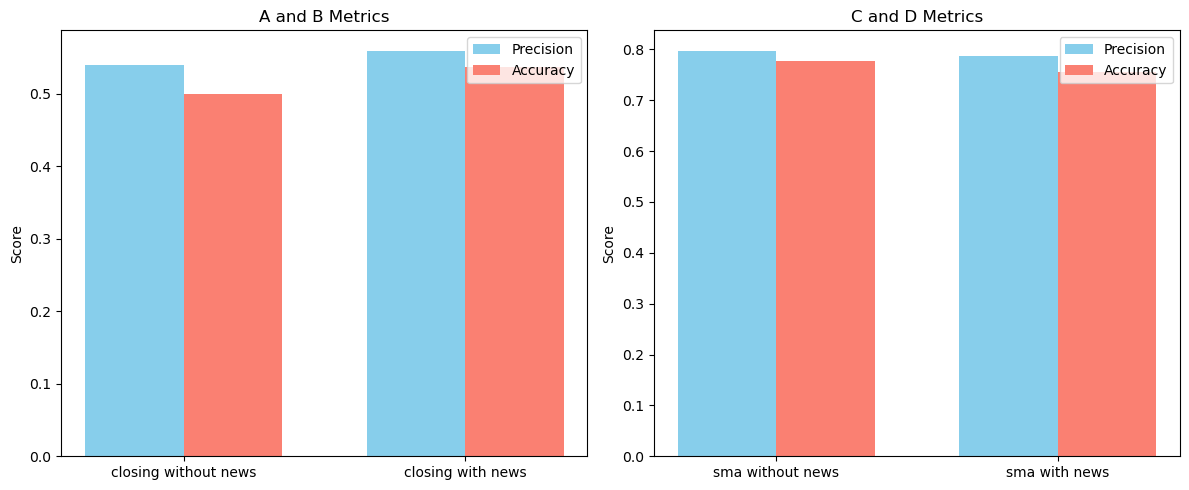

[*********************100%***********************]  1 of 1 completed

####################### NVDA ##############################


Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Hyperparameters:
{'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Precision with Best Hyperparameters: 0.54

Confusion Matrix:
[[41 82]
 [38 95]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.52      0.33      0.41       123
         1.0       0.54      0.71      0.61       133

    accuracy                           0.53       256
   macro avg       0.53      0.52      0.51       256
weighted avg       0.53      0.53      0.51       256


Feature Importances:
             Feature  Importance
5     Close_Ratio_60    0.094797
10    Volatility_250    0.091812
7      Volatility_60    0.090889
1      Close_Ratio_2    0.090580
3      Close_Ratio_5    0.090477
13   Volatility_1000    0.088763
0        Log_Returns    0.088752
8    Close_Ratio_250    0.080687
11  Close_Ratio_1000    0.077462
9 

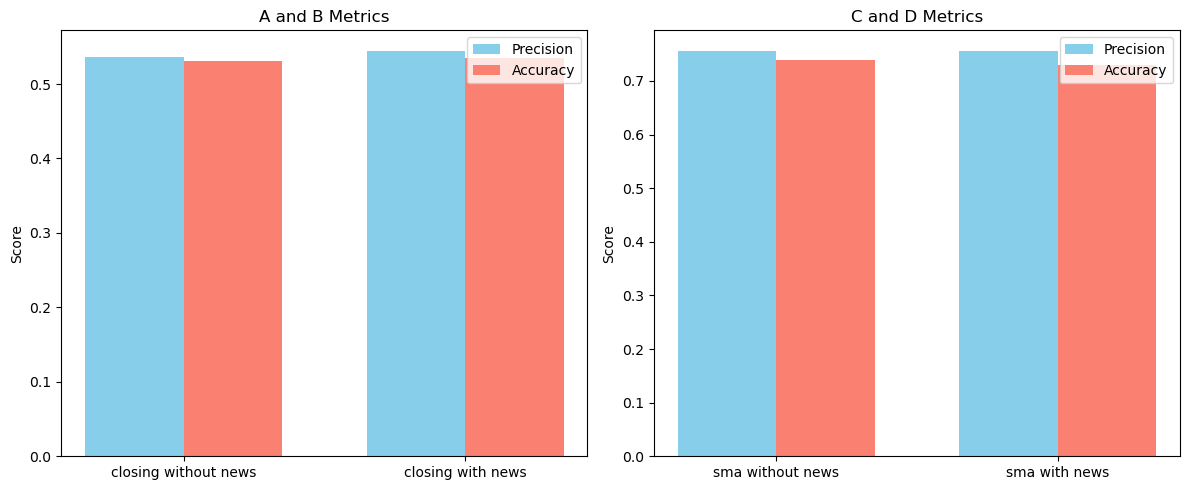

[*********************100%***********************]  1 of 1 completed

####################### AAPL ##############################


Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Hyperparameters:
{'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}

Precision with Best Hyperparameters: 0.56

Confusion Matrix:
[[ 43  89]
 [ 54 114]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.44      0.33      0.38       132
         1.0       0.56      0.68      0.61       168

    accuracy                           0.52       300
   macro avg       0.50      0.50      0.50       300
weighted avg       0.51      0.52      0.51       300


Feature Importances:
             Feature  Importance
0        Log_Returns    0.099384
1      Close_Ratio_2    0.095616
3      Close_Ratio_5    0.093672
5     Close_Ratio_60    0.087331
13   Volatility_1000    0.086376
7      Volatility_60    0.085599
11  Close_Ratio_1000    0.085135
8    Close_Ratio_250    0.084960
10    Volatility_250    0.08477

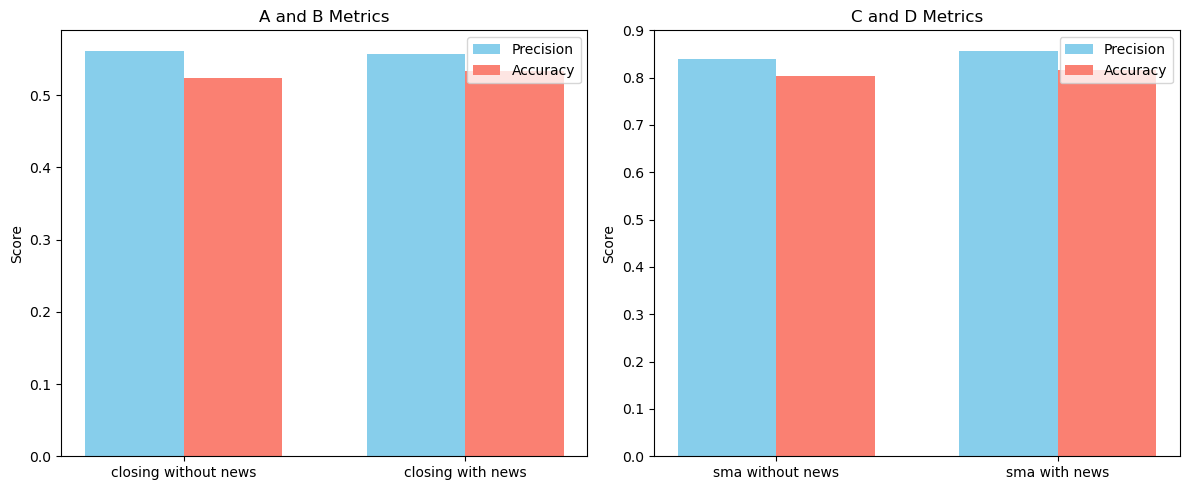

[*********************100%***********************]  1 of 1 completed

####################### GOOG ##############################


Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Hyperparameters:
{'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Precision with Best Hyperparameters: 0.58

Confusion Matrix:
[[ 54  86]
 [ 45 117]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.39      0.45       140
         1.0       0.58      0.72      0.64       162

    accuracy                           0.57       302
   macro avg       0.56      0.55      0.55       302
weighted avg       0.56      0.57      0.55       302


Feature Importances:
             Feature  Importance
7      Volatility_60    0.098969
3      Close_Ratio_5    0.092663
1      Close_Ratio_2    0.091649
11  Close_Ratio_1000    0.089987
5     Close_Ratio_60    0.089920
0        Log_Returns    0.088340
13   Volatility_1000    0.086211
10    Volatility_250    0.085153
8    Close_Ratio_250    0.08011

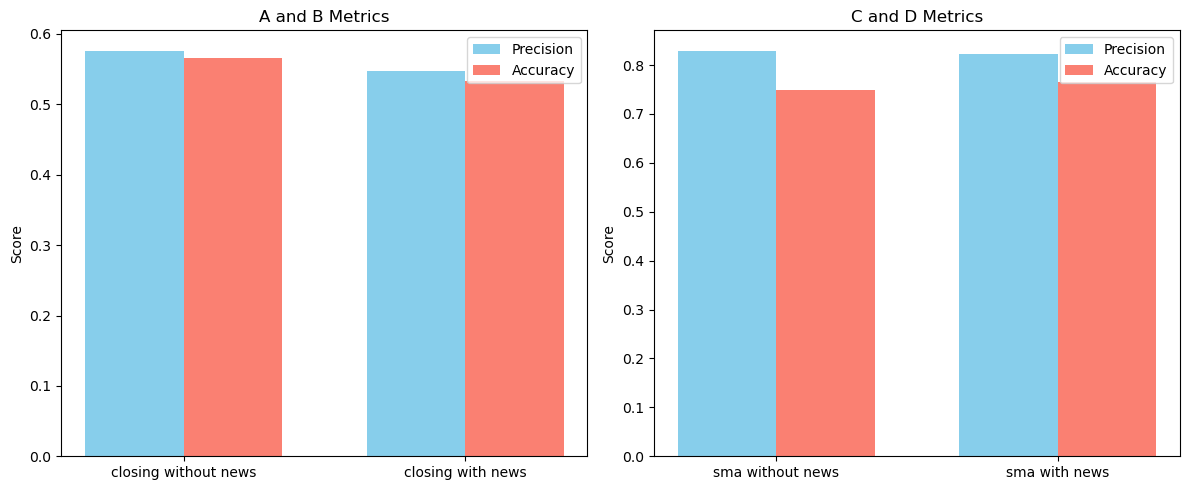

[*********************100%***********************]  1 of 1 completed

####################### MSFT ##############################


Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Hyperparameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}

Precision with Best Hyperparameters: 0.54

Confusion Matrix:
[[  9 119]
 [  8 137]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.07      0.12       128
         1.0       0.54      0.94      0.68       145

    accuracy                           0.53       273
   macro avg       0.53      0.51      0.40       273
weighted avg       0.53      0.53      0.42       273


Feature Importances:
             Feature  Importance
11  Close_Ratio_1000    0.095013
1      Close_Ratio_2    0.094764
5     Close_Ratio_60    0.091136
3      Close_Ratio_5    0.090836
0        Log_Returns    0.089986
8    Close_Ratio_250    0.088659
7      Volatility_60    0.085162
10    Volatility_250    0.083449
13   Volatility_1000    0.07596

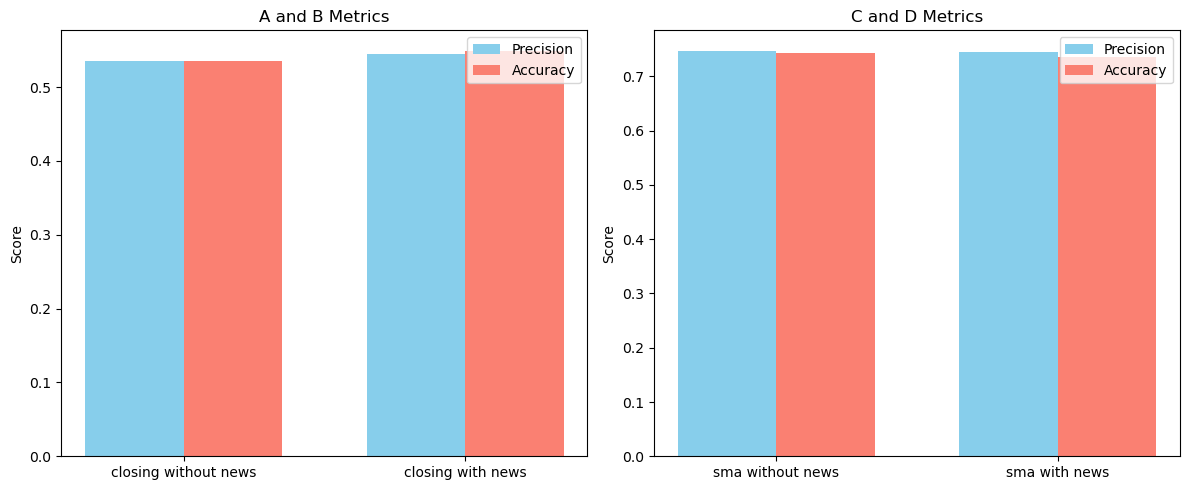

In [85]:
amazon = stock('AMZN')
nvidia = stock('NVDA')
apple = stock('AAPL')
google = stock('GOOG')
msft = stock('MSFT')
stocks = [amazon,nvidia,apple,google,msft]
stonk_dict = {}
for stonk in stocks:
    print(f"####################### {stonk.ticker} ##############################")
    stonk_df = stonk.incorporate_news(start_date,end_date)
    A = stonk.random_forest(stonk_df,features,target,start_date,end_date)
    B = stonk.random_forest(stonk_df,features_news,target,start_date,end_date)
    C = stonk.random_forest(stonk_df,features,target_sma,start_date,end_date)
    D = stonk.random_forest(stonk_df,features_news,target_sma,start_date,end_date)
    stonk_dict[f'{stonk.ticker}'] = [A,B,C,D]
    # Data preparation
    labels_A_B = ['closing without news', 'closing with news']
    precision_A_B = [A['precision'], B['precision']]
    accuracy_A_B = [A['accuracy'], B['accuracy']]
    
    labels_C_D = ['sma without news', 'sma with news']
    precision_C_D = [C['precision'], D['precision']]
    accuracy_C_D = [C['accuracy'], D['accuracy']]
    
    # Bar width
    bar_width = 0.35
    x_A_B = np.arange(len(labels_A_B))
    x_C_D = np.arange(len(labels_C_D))
    
    # Plotting histograms for A and B
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].bar(x_A_B - bar_width / 2, precision_A_B, bar_width, label='Precision', color='skyblue')
    ax[0].bar(x_A_B + bar_width / 2, accuracy_A_B, bar_width, label='Accuracy', color='salmon')
    ax[0].set_title('A and B Metrics')
    ax[0].set_xticks(x_A_B)
    ax[0].set_xticklabels(labels_A_B)
    ax[0].set_ylabel('Score')
    ax[0].legend()

    # Plotting histograms for C and D
    ax[1].bar(x_C_D - bar_width / 2, precision_C_D, bar_width, label='Precision', color='skyblue')
    ax[1].bar(x_C_D + bar_width / 2, accuracy_C_D, bar_width, label='Accuracy', color='salmon')
    ax[1].set_title('C and D Metrics')
    ax[1].set_xticks(x_C_D)
    ax[1].set_xticklabels(labels_C_D)
    ax[1].set_ylabel('Score')
    ax[1].legend()
    
    # Display plots
    plt.tight_layout()
    plt.show()


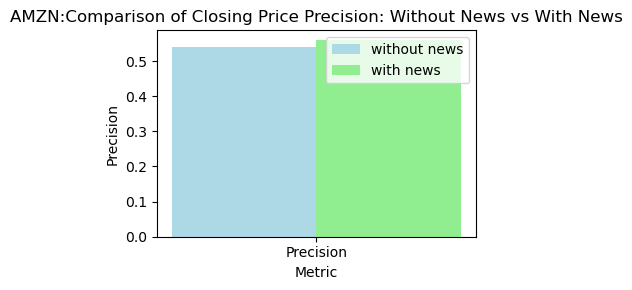

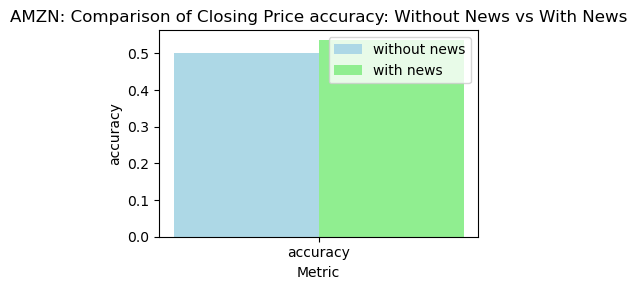

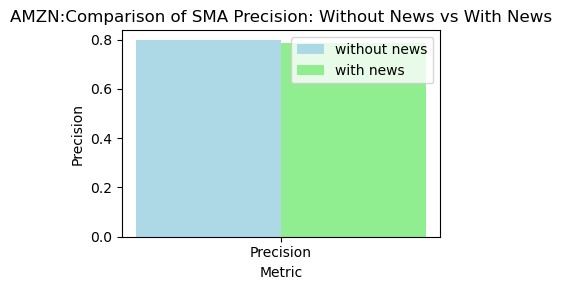

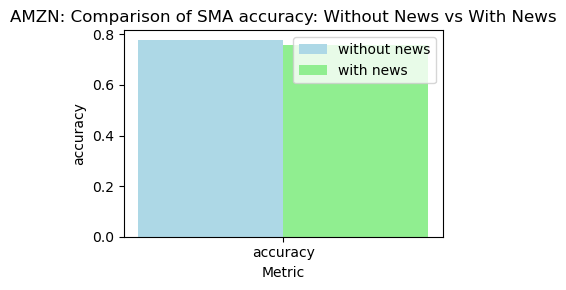

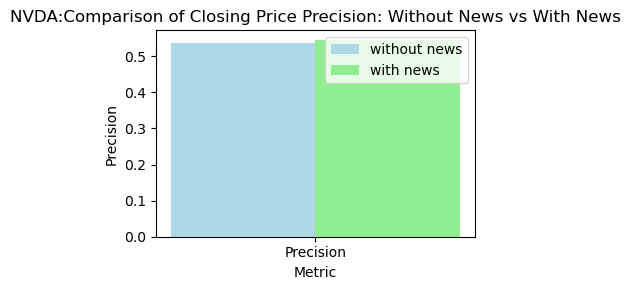

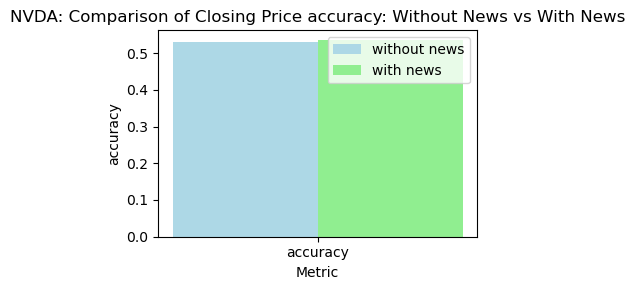

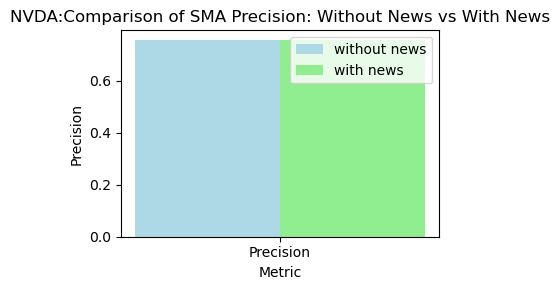

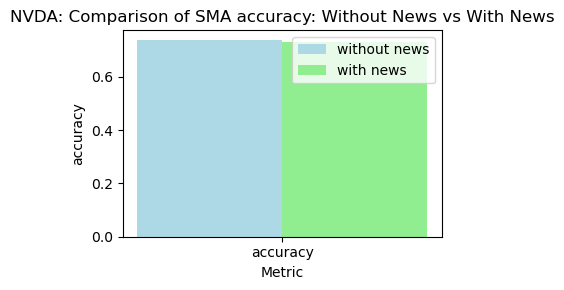

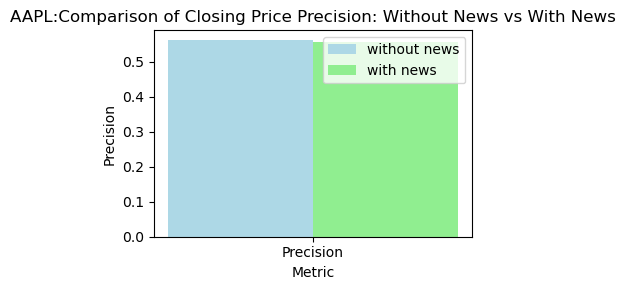

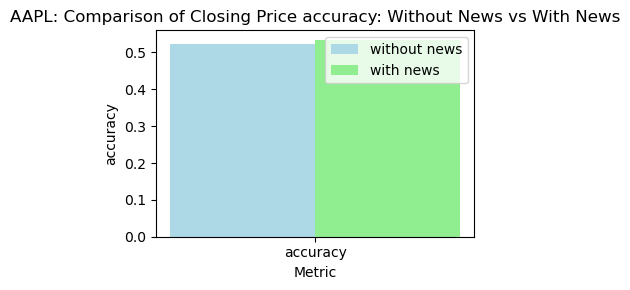

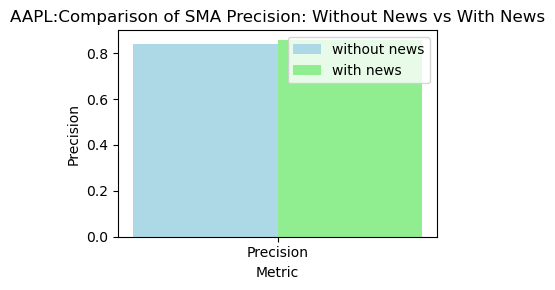

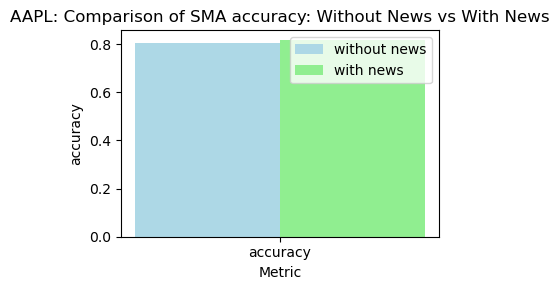

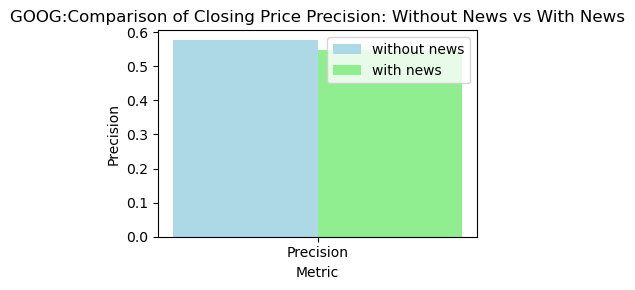

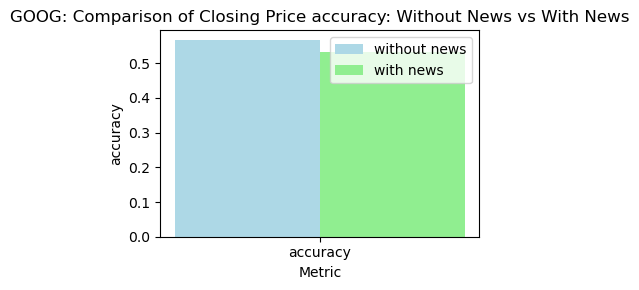

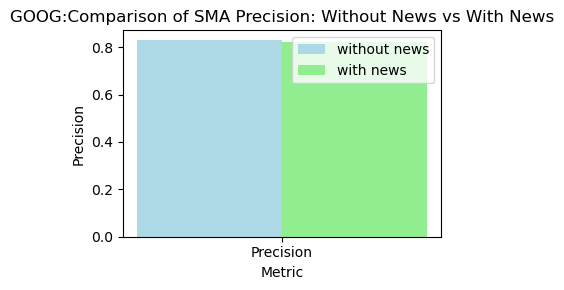

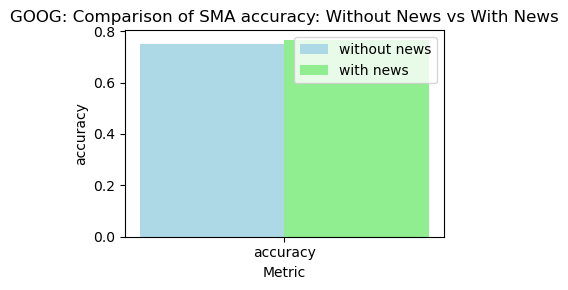

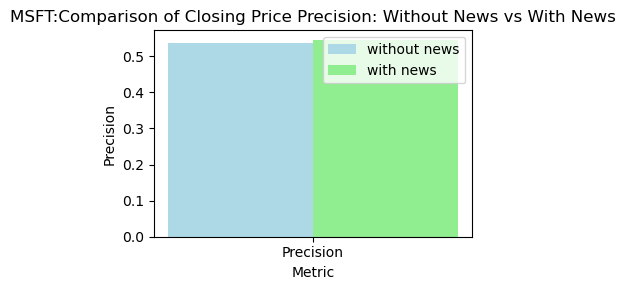

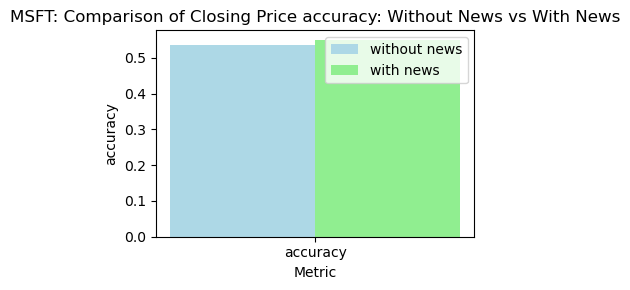

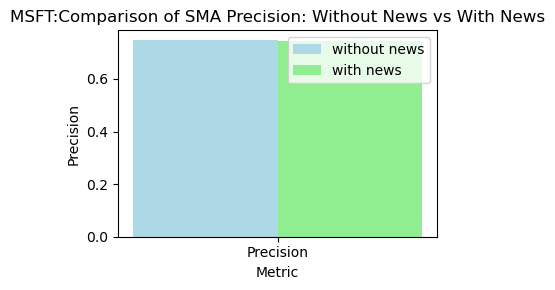

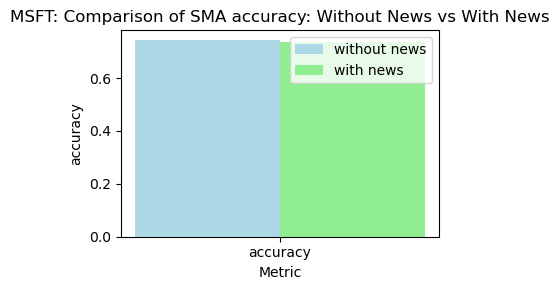

In [107]:
for stonk in stocks:
    A = stonk_dict[f'{stonk.ticker}'][0]
    B = stonk_dict[f'{stonk.ticker}'][1]
    C = stonk_dict[f'{stonk.ticker}'][2]
    D = stonk_dict[f'{stonk.ticker}'][3]
    
    # Data preparation
    labels_A_B = ['without news', 'with news']
    precision_A_B = [A['precision'], B['precision']]
    accuracy_A_B = [A['accuracy'], B['accuracy']]
    
    labels_C_D = ['without news', 'with news']
    precision_C_D = [C['precision'], D['precision']]
    accuracy_C_D = [C['accuracy'], D['accuracy']]

    # Data for the bars
    labels = ['Precision']
    values = [A['precision'], B['precision']]
    bar_width = 0.1
    
    # X-axis positions for the bars
    x = np.arange(len(labels))
    plt.figure(figsize=(4, 3))  # Set width=4 inches, height=3 inches

    # Plotting
    plt.bar(x - bar_width/2, [A['precision']], width=bar_width, color='lightblue', label='without news')
    plt.bar(x + bar_width/2, [B['precision']], width=bar_width, color='lightgreen', label='with news')
    
    # Labels and title
    plt.xlabel('Metric')
    plt.ylabel('Precision')
    plt.title(f'{stonk.ticker}:Comparison of Closing Price Precision: Without News vs With News')
    plt.xticks(x, labels)  # Set x-ticks to the labels
    plt.legend()
    
    # Show plot
    plt.tight_layout()
    plt.show()
    # Data for the bars
    labels = ['accuracy']
    values = [A['accuracy'], B['accuracy']]
    bar_width = 0.1
    
    # X-axis positions for the bars
    x = np.arange(len(labels))
    plt.figure(figsize=(4, 3))  # Set width=4 inches, height=3 inches

    # Plotting
    plt.bar(x - bar_width/2, [A['accuracy']], width=bar_width, color='lightblue', label='without news')
    plt.bar(x + bar_width/2, [B['accuracy']], width=bar_width, color='lightgreen', label='with news')
    
    # Labels and title
    plt.xlabel('Metric')
    plt.ylabel('accuracy')
    plt.title(f'{stonk.ticker}: Comparison of Closing Price accuracy: Without News vs With News')
    plt.xticks(x, labels)  # Set x-ticks to the labels
    plt.legend()
    
    # Show plot
    plt.tight_layout()
    plt.show()

    
    
    # Data preparation
    labels_C_D = ['without news', 'with news']
    precision_C_D = [C['precision'], D['precision']]
    accuracy_C_D = [C['accuracy'], D['accuracy']]
    
    labels_C_D = ['without news', 'with news']
    precision_C_D = [C['precision'], D['precision']]
    accuracy_C_D = [C['accuracy'], D['accuracy']]

    # Data for the bars
    labels = ['Precision']
    values = [C['precision'], D['precision']]
    bar_width = 0.1
    
    # X-axis positions for the bars
    x = np.arange(len(labels))
    plt.figure(figsize=(4, 3))  # Set width=4 inches, height=3 inches

    # Plotting
    plt.bar(x - bar_width/2, [C['precision']], width=bar_width, color='lightblue', label='without news')
    plt.bar(x + bar_width/2, [D['precision']], width=bar_width, color='lightgreen', label='with news')
    
    # Labels and title
    plt.xlabel('Metric')
    plt.ylabel('Precision')
    plt.title(f'{stonk.ticker}:Comparison of SMA Precision: Without News vs With News')
    plt.xticks(x, labels)  # Set x-ticks to the labels
    plt.legend()
    
    # Show plot
    plt.tight_layout()
    plt.show()
    # Data for the bars
    labels = ['accuracy']
    values = [C['accuracy'], D['accuracy']]
    bar_width = 0.1
    
    # X-axis positions for the bars
    x = np.arange(len(labels))
    plt.figure(figsize=(4, 3))  # Set width=4 inches, height=3 inches

    # Plotting
    plt.bar(x - bar_width/2, [C['accuracy']], width=bar_width, color='lightblue', label='without news')
    plt.bar(x + bar_width/2, [D['accuracy']], width=bar_width, color='lightgreen', label='with news')
    
    # Labels and title
    plt.xlabel('Metric')
    plt.ylabel('accuracy')
    plt.title(f'{stonk.ticker}: Comparison of SMA accuracy: Without News vs With News')
    plt.xticks(x, labels)  # Set x-ticks to the labels
    plt.legend()
    
    # Show plot
    plt.tight_layout()
    plt.show()

    



